# Community Detection: ICPSR Datasets
1. Load citation data from ICPSR Bibliography and Dimensions database
2. Make bipartite graph of datasets cited in papers
3. Project bipartite graph and analyze projected graph
4. Detect dataset communities with k-clique percolation
5. Output files for visualization in Tableau

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx import bipartite
from common_functions import * #helper functions

## ICPSR Bibliography: Studies and Series

In [2]:
df_studies_all = pd.read_excel('../data/ICPSR_BIBLIOGRAPHY.xlsx', sheet_name=1)
df_studies = df_studies_all[(df_studies_all['PERMIT']=="AVAILABLE") & (df_studies_all['OBJECTTYPE']=="study") ]
df_studies = df_studies.rename(columns={"DOI":"STUDY_DOI"})
df_studies = df_studies.drop_duplicates(subset=['STUDY'])
df_studies['STUDY'] = df_studies['STUDY'].astype(np.int64)
df_studies['years_available'] = 2022 - df_studies['ORIGRELDATE'].dt.year

df_series =  df_studies[df_studies.SERIES.notna()]
df_series['SERIES'] = df_series['SERIES'].astype(np.int64)
df_series = df_series.drop_duplicates(['SERIES'])
df_series[['STUDY', 'NAME', 'STUDY_DOI']] = np.nan

study_in_series = df_studies[df_studies.SERIES.notna()]
study_in_series['STUDY'] = study_in_series['STUDY'].astype(np.int64)
study_in_series['SERIES'] = study_in_series['SERIES'].astype(np.int64)
study_series = study_in_series[["STUDY", "SERIES"]]

study_no_series = df_studies[df_studies.SERIES.isna()]
study_no_series['STUDY'] = study_no_series['STUDY'].astype(np.int64)

print("UNIQUE ICPSR STUDIES:", df_studies.STUDY.nunique())
print("UNIQUE ICPSR SERIES:", df_studies.SERIES.nunique())

UNIQUE ICPSR STUDIES: 10491
UNIQUE ICPSR SERIES: 278


/var/folders/5k/52wwg20n7md17xdcgtnz5lzw0000gs/T/ipykernel_24558/2757375394.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series['SERIES'] = df_series['SERIES'].astype(np.int64)
/var/folders/5k/52wwg20n7md17xdcgtnz5lzw0000gs/T/ipykernel_24558/2757375394.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series[['STUDY', 'NAME', 'STUDY_DOI']] = np.nan
/var/folders/5k/52wwg20n7md17xdcgtnz5lzw0000gs/T/ipykernel_24558/2757375394.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy

## ICPSR Bibliography: Papers

In [3]:
df_original = pd.read_excel('../data/ICPSR_BIBLIOGRAPHY.xlsx', sheet_name=0)
df_original = df_original.rename(columns={"DOI":"REF_DOI"})
df_original['REF_ID'] = df_original['REF_ID'].astype(np.int64)
df_original['REF_PAPER'] = 'P_' + df_original['REF_ID'].astype(str)
df_original = df_original[(df_original['YEAR_PUB'] >= 1962) & (df_original['YEAR_PUB'] <= 2022)] #filter by pub date
df_original['TITLE_lower'] = df_original['TITLE'].astype(str).str.lower() # deduplicate publications
df_original = df_original.drop_duplicates(subset=['TITLE_lower'])

df_enriched = pd.read_csv('../data/ICPSR_DIMENSIONS.csv')
df_enriched = df_enriched.dropna(subset=['doi'])
df_enriched = df_enriched.rename(columns={"doi":"REF_DOI"})

df_bib = pd.merge(df_original, df_enriched, on="REF_DOI", how="left")

print("TOTAL PUBLICATIONS IN ORIGINAL BIBLIOGRAPHY:", df_original.REF_PAPER.nunique())
print("UNIQUE PUBLICATIONS IN ORIGINAL BIBLIOGRAPHY:", df_original.REF_PAPER.nunique())
print("UNIQUE PUBLICATIONS IN BIBLIOGRAPHY WITH DIMENSIONS METADATA:", df_enriched.REF_DOI.nunique())

TOTAL PUBLICATIONS IN ORIGINAL BIBLIOGRAPHY: 103285
UNIQUE PUBLICATIONS IN ORIGINAL BIBLIOGRAPHY: 103285
UNIQUE PUBLICATIONS IN BIBLIOGRAPHY WITH DIMENSIONS METADATA: 44639


## Model data use
Data use is a binary relation indicated by ICPSR `STUDY` and `SERIES`:
- separate the Bibliography by `SERIES_NUMS` and `STUD_NUMS`
    - if a paper cites `SERIES` only: E_ (`REF_DATA`)
    - if a paper cites `STUDY`:
        - if the `STUDY` does not belong to a `SERIES` keep its `STUDY` number: S_ (`REF_DATA`; `REF_STUDY`)
        - if the `STUDY` belongs to a `SERIES` keep its `SERIES` number: E_ (`REF_DATA`) and its `STUDY` number: S_ (`REF_STUDY`)

In [4]:
df_bib_series =  df_bib[df_bib.STUD_NUMS.isna()]
df_bib_series['SERIES'] = df_bib_series.SERIES_NUMS.str.split(";")
exploded_bib_series = df_bib_series.explode("SERIES")
exploded_bib_series["SERIES"] = exploded_bib_series["SERIES"].astype(str).astype(float)

exploded_bib_series = exploded_bib_series.drop(columns=['SERIES_NUMS', 'STUD_NUMS'])
exploded_bib_series[["STUDY"]] = np.nan
exploded_bib_series["REF_DATA"] = 'E_' + exploded_bib_series["SERIES"].astype(str)

df_bib_series = exploded_bib_series.merge(df_series, on='SERIES', how="left")
df_bib_series = df_bib_series.drop(columns=['STUDY_y'])
df_bib_series = df_bib_series.rename(columns={'STUDY_x':'STUDY'})

print("UNIQUE PUBLICATIONS IN BIBLIOGRAPHY THAT USE SERIES ONLY:", df_bib_series.REF_PAPER.nunique(), "of", df_bib.REF_PAPER.nunique())
print("UNIQUE SERIES USED IN THE BIBLIOGRAPHY:", df_bib_series.REF_DATA.nunique(), "of", df_series.SERIES.nunique())

df_bib_studies = df_bib[df_bib.STUD_NUMS.notna()]
df_bib_studies['STUDY'] = df_bib_studies.STUD_NUMS.str.split(";")

exploded_bib_studies = df_bib_studies.explode("STUDY")
exploded_bib_studies["STUDY"] = exploded_bib_studies["STUDY"].astype(str).astype(int)

exploded_bib_studies_series = exploded_bib_studies.merge(study_series, on='STUDY', how='left')
exploded_bib_studies_no_series = exploded_bib_studies_series[exploded_bib_studies_series.SERIES.isna()]
exploded_bib_studies_no_series = exploded_bib_studies_no_series.drop(columns=['SERIES_NUMS', 'STUD_NUMS'])
exploded_bib_studies_no_series["REF_DATA"] = 'S_' + exploded_bib_studies_no_series["STUDY"].astype(str)
exploded_bib_studies_no_series["REF_STUDY"] = 'S_' + exploded_bib_studies_no_series["STUDY"].astype(str) # added this

df_bib_studies_no_series = exploded_bib_studies_no_series.merge(df_studies, on='STUDY', how="left")
df_bib_studies_no_series = df_bib_studies_no_series.drop(columns=['SERIES_y'])
df_bib_studies_no_series = df_bib_studies_no_series.rename(columns={'SERIES_x':'SERIES'})

print("UNIQUE PUBLICATIONS IN BIBLIOGRAPHY THAT USE STUDIES THAT ARE NOT IN SERIES:", df_bib_studies_no_series.REF_PAPER.nunique(), "of", df_bib.REF_PAPER.nunique())
print("UNIQUE STUDIES NOT IN SERIES USED IN THE BIBLIOGRAPHY:", df_bib_studies_no_series.REF_DATA.nunique(), "of", study_no_series.STUDY.nunique())

df_bib_studies_no_series = df_bib_studies_no_series.dropna(subset=['NAME'])

df_studies_in_series = exploded_bib_studies_series[exploded_bib_studies_series.SERIES.notna()]
df_studies_in_series = df_studies_in_series.drop(columns=['SERIES_NUMS', 'STUD_NUMS'])

df_studies_in_series['STUDY'] = df_studies_in_series['STUDY'].astype(np.int64)
df_studies_in_series['SERIES'] = df_studies_in_series['SERIES'].astype(np.int64)

df_studies_in_series = df_studies_in_series.drop_duplicates(['REF_ID', 'SERIES'])
df_studies_in_series["REF_DATA"] = 'E_' + df_studies_in_series["SERIES"].astype(str)
df_studies_in_series["REF_STUDY"] = 'S_' + df_studies_in_series["STUDY"].astype(str)

df_bib_studies_in_series = df_studies_in_series.merge(df_studies, on='STUDY', how="left")
df_bib_studies_in_series = df_bib_studies_in_series.drop(columns=['SERIES_y'])
df_bib_studies_in_series = df_bib_studies_in_series.rename(columns={'SERIES_x':'SERIES'})

print("UNIQUE PUBLICATIONS IN BIBLIOGRAPHY THAT USE STUDIES IN SERIES:", df_bib_studies_in_series.REF_PAPER.nunique(), "of", df_bib.REF_PAPER.nunique())
print("UNIQUE STUDIES IN SERIES USED IN THE BIBLIOGRAPHY:", df_bib_studies_in_series.REF_DATA.nunique(), "of", study_series.SERIES.nunique())

/var/folders/5k/52wwg20n7md17xdcgtnz5lzw0000gs/T/ipykernel_24558/775997861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bib_series['SERIES'] = df_bib_series.SERIES_NUMS.str.split(";")


UNIQUE PUBLICATIONS IN BIBLIOGRAPHY THAT USE SERIES ONLY: 9177 of 103285
UNIQUE SERIES USED IN THE BIBLIOGRAPHY: 150 of 278


/var/folders/5k/52wwg20n7md17xdcgtnz5lzw0000gs/T/ipykernel_24558/775997861.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bib_studies['STUDY'] = df_bib_studies.STUD_NUMS.str.split(";")


UNIQUE PUBLICATIONS IN BIBLIOGRAPHY THAT USE STUDIES THAT ARE NOT IN SERIES: 33719 of 103285
UNIQUE STUDIES NOT IN SERIES USED IN THE BIBLIOGRAPHY: 3475 of 3949
UNIQUE PUBLICATIONS IN BIBLIOGRAPHY THAT USE STUDIES IN SERIES: 63412 of 103285
UNIQUE STUDIES IN SERIES USED IN THE BIBLIOGRAPHY: 274 of 278


## Make dataframe

In [5]:
coarse_frames = [df_bib_studies_no_series, df_bib_studies_in_series]
df_study = pd.concat(coarse_frames)

print("UNIQUE ICPSR STUDIES USED BY PAPERS IN BIBLIOGRAPHY:", df_study.STUDY.nunique())
print("UNIQUE ICPSR SERIES USED BY PAPERS IN BIBLIOGRAPHY:", df_study.SERIES.nunique())

df_study = df_study.drop(columns=['REF_DOI', 
                                    'TITLE_lower',
                               'SEC_TITLE',
                               'SUBJECT',
                               'STATUS',
                               'category_sdg',
                               'PERMIT',
                               'OBJECTTYPE',
                               'ALTTITLE2','ALTTITLE3','ALTTITLE4','ALTTITLE5','ALTTITLE6','ALTTITLE7',
                               'DESCRIPTION_2','DESCRIPTION_3','DESCRIPTION_4','DESCRIPTION_5'])

# df_study.to_csv('../data/REF_PAPER_DATA.csv',index=False)

UNIQUE ICPSR STUDIES USED BY PAPERS IN BIBLIOGRAPHY: 6576
UNIQUE ICPSR SERIES USED BY PAPERS IN BIBLIOGRAPHY: 274


## Make bipartite graph

In [6]:
S = make_bipartite(df_study,'REF_ID','REF_DATA', 'S')

Network is connected: False
REF_ID 90922
REF_DATA 3363


In [7]:
S_paper, S_study = get_node_sets(S)

Left nodes: 90922
Right nodes: 3363


In [8]:
graph_metrics(S)

Network density: 2.3078739536439104e-05
Network transitivity: 0
Network assortativity: -0.19788716483600688
Network is connected: False
Network components: 1687


In [9]:
nx.info(S)

"Graph named 'S' with 94285 nodes and 102580 edges"

In [10]:
bipartite.density(S, S_study)

0.00033548016437389945

## Make and save graph projections

In [11]:
%%time

S_weighted = project_graph(S, 1, 2, "data", "data_paper_edgelist", "data_paper_nodelist", "S")

Confirming partition type: <class 'str'>
Removing 21734 edges of weight less than 2
Removing 2365 isolated nodes
Graph named 'S' with 998 nodes and 3208 edges
CPU times: user 1.29 s, sys: 20.6 ms, total: 1.31 s
Wall time: 1.32 s


In [12]:
save_graph(S_weighted, "data_paper_projected")

## Analyze projected graph

In [13]:
# df_study = pd.read_csv("../data/REF_PAPER_DATA.csv", low_memory=False)
df_study_edges = pd.read_csv("../outputs/data_paper_edgelist.csv")
df_study_nodes = pd.read_csv("../outputs/data_paper_nodelist.csv")
print("Nodes:",len(df_study_nodes))
print("Edges:",len(df_study_edges))
data_nodes = df_study.merge(df_study_nodes, on='REF_DATA', how="inner").drop_duplicates(subset=['REF_DATA'])
data_nodes = data_nodes.replace({np.nan: "None"}) #replaces nan with string "None" and fixes gefx file

Nodes: 998
Edges: 3208


In [14]:
S = load_graph("data_paper_projected")
add_attributes(S, "data", data_nodes)
graph_metrics(S)

Graph named 'S' with 998 nodes and 3208 edges
Network density: 0.006448202322398056
Network transitivity: 0.2810711105457321
Network assortativity: -0.023656077212027518
Network is connected: False
Network components: 80


In [15]:
sample_node = data_nodes.REF_DATA.iloc[555]
S.nodes[sample_node]

{'degree': 6,
 'citations': 118,
 'between': 3.4255531012799416e-05,
 'study_number': 'S_25681',
 'study_name': 'School Survey on Crime and Safety (SSOCS), 2004',
 'study_series': 'None',
 'study_owner': 'NACJD',
 'study_funding': 'United States Department of Education. Office of Safe and Drug-Free Schools',
 'study_geo': 'United States',
 'study_terms': 'crime; crime in schools; crime reporting; crime statistics; educational environment; juvenile crime; offenses; school security; school violence; student behavior',
 'study_release': Timestamp('2010-03-04 08:36:03')}

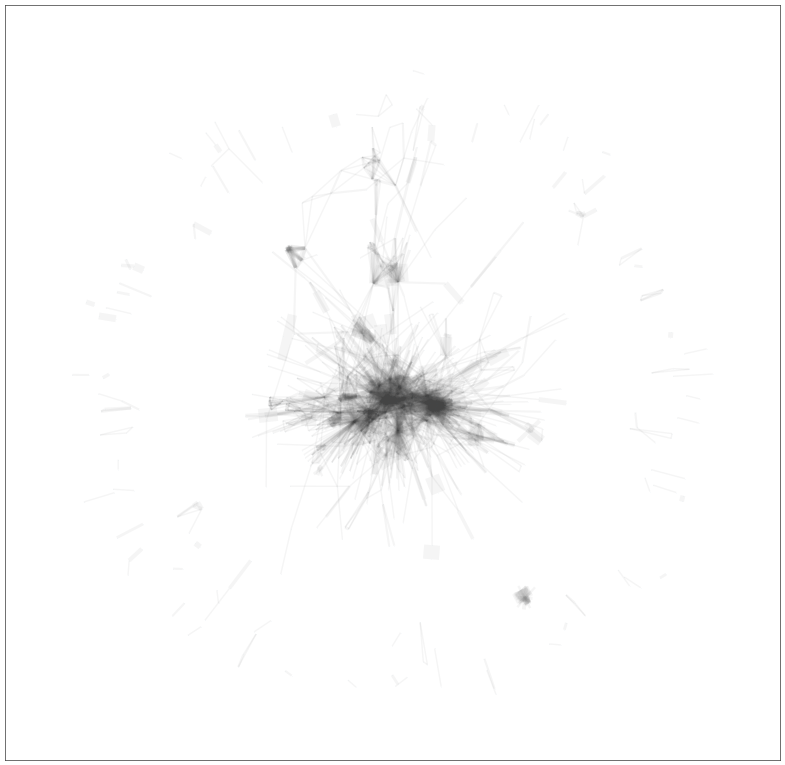

In [16]:
plot_graph(S, "data_paper_network_overview")

In [17]:
sub_S = get_largest_subgraph(S)

Largest subgraph density: 0.006448202322398056
Largest subgraph transitivity: 0.2810711105457321


Force-directed visualization shows center and periphery
- each pair of linked `DATASETS` are used in the same `PAPER`
- no nodes or labels for now, just want to see shape

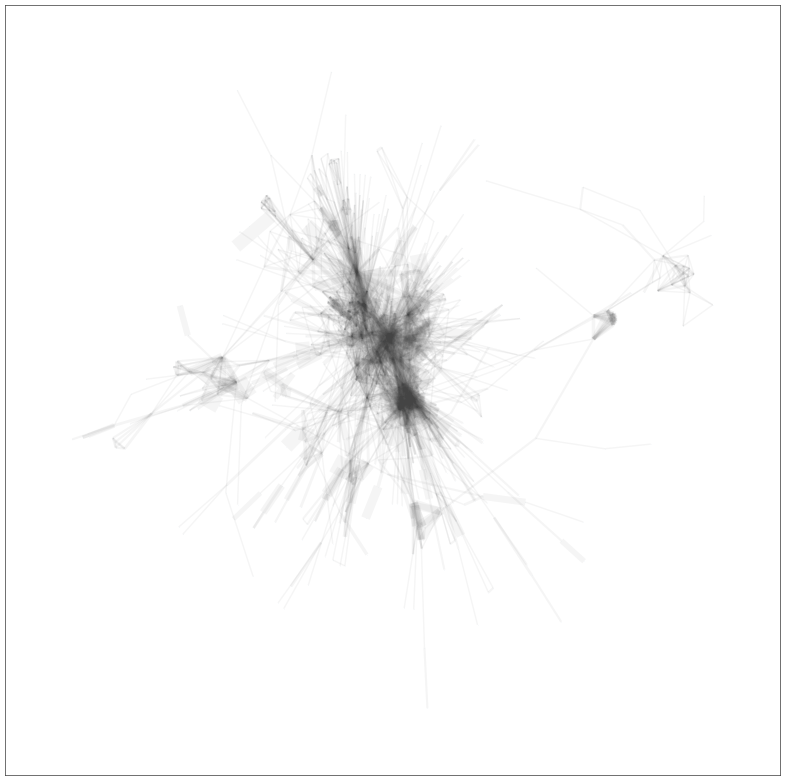

In [18]:
plot_graph(sub_S, "data_paper_network_subgraph")

`DATA` heaviest edges
- Pairs of data used together the most

Breaks:  [2.0, 8.0, 25.0, 57.0, 147.0]
Size:  23
EDGE WEIGHT: 147 
 SOURCE (study): Uniform Crime Reporting Program Data [United States]: 1975-1997 
 SOURCE (series): Uniform Crime Reporting Program Data Series 
 SOURCE (owner): NACJD 
 SOURCE (number): E_57 
 SOURCE (degree): 115 
 SOURCE (betweenness): 0.16670873402242944 
 SOURCE (citations): 1365 
 TARGET (study): Law Enforcement Management and Administrative Statistics (LEMAS): 1997 Sample Survey of Law Enforcement Agencies 
 TARGET (series): Law Enforcement Management and Administrative Statistics (LEMAS) Series 
 TARGET (owner): NACJD 
 TARGET (number): E_92 
 TARGET (degree): 33 
 TARGET (betweenness): 0.019936962776600956 
 TARGET (citations): 536 

EDGE WEIGHT: 142 
 SOURCE (study): Survey of Public Participation in the Arts, 1982-2008 [United States] 
 SOURCE (series): None 
 SOURCE (owner): NADAC 
 SOURCE (number): S_35527 
 SOURCE (degree): 10 
 SOURCE (betweenness): 0.0010203242398854147 
 SOURCE (citations): 395 
 TARGET

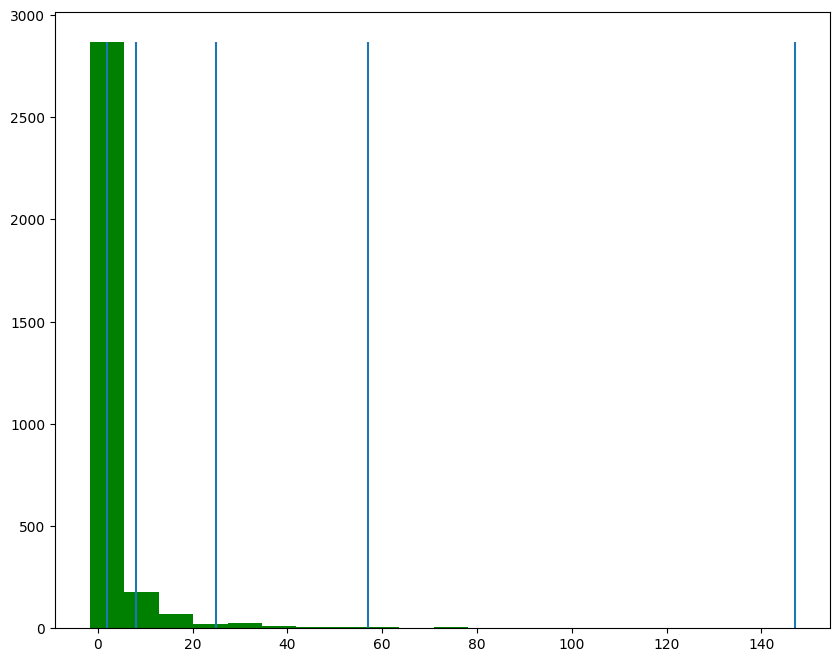

In [19]:
find_heavy_edges(S, 4)

Highest betweenness: Data that connect disparate parts of the network

In [20]:
find_between_nodes(S, 10)

Breaks:  [0.0, 0.0007672146955229811, 0.002628002501014178, 0.0051369626436841625, 0.009015833408637946, 0.015707068367419114, 0.02710846967627627, 0.038723531902790424, 0.057804008852306035, 0.10980906999003848, 0.16670873402242944]
Size:  998
BETWEENNESS: 0.16670873402242944 
 DEGREE: 115 
 SERIES: Uniform Crime Reporting Program Data Series 
 STUDY: Uniform Crime Reporting Program Data [United States]: 1975-1997 
 STUDY NUMBER: E_57 
 OWNER: NACJD 
 CITATIONS: 1365 

BETWEENNESS: 0.10980906999003848 
 DEGREE: 113 
 SERIES: General Social Survey Series 
 STUDY: General Social Survey, 1972-2016 [Cumulative File] 
 STUDY NUMBER: E_28 
 OWNER: ICPSR 
 CITATIONS: 736 

BETWEENNESS: 0.10972579683348439 
 DEGREE: 109 
 SERIES: American National Election Study (ANES) Series 
 STUDY: ANES 1988 Time Series Study 
 STUDY NUMBER: E_3 
 OWNER: ICPSR 
 CITATIONS: 870 

BETWEENNESS: 0.1053070988292498 
 DEGREE: 117 
 SERIES: Current Population Survey Series 
 STUDY: Current Population Survey: Annu

Highest degree: Data used the most with all other data

In [21]:
find_central_nodes(S, 5)

Breaks:  [1.0, 5.0, 17.0, 40.0, 80.0, 117.0]
Size:  5
DEGREE: 117 
 BETWEENNESS: 0.1053070988292498 
 SERIES: Current Population Survey Series 
 STUDY: Current Population Survey: Annual Demographic File, 1998 
 STUDY NUMBER: E_24 
 OWNER: ICPSR 
 CITATIONS: 1144 

DEGREE: 115 
 BETWEENNESS: 0.16670873402242944 
 SERIES: Uniform Crime Reporting Program Data Series 
 STUDY: Uniform Crime Reporting Program Data [United States]: 1975-1997 
 STUDY NUMBER: E_57 
 OWNER: NACJD 
 CITATIONS: 1365 

DEGREE: 113 
 BETWEENNESS: 0.10980906999003848 
 SERIES: General Social Survey Series 
 STUDY: General Social Survey, 1972-2016 [Cumulative File] 
 STUDY NUMBER: E_28 
 OWNER: ICPSR 
 CITATIONS: 736 

DEGREE: 109 
 BETWEENNESS: 0.10972579683348439 
 SERIES: American National Election Study (ANES) Series 
 STUDY: ANES 1988 Time Series Study 
 STUDY NUMBER: E_3 
 OWNER: ICPSR 
 CITATIONS: 870 

DEGREE: 80 
 BETWEENNESS: 0.05159067505740006 
 SERIES: National Health Interview Survey Series 
 STUDY: Heal

Plot high degree centrality hubs only

Top degree datasets: ['E_24', 'E_40', 'E_57', 'E_3', 'E_28']


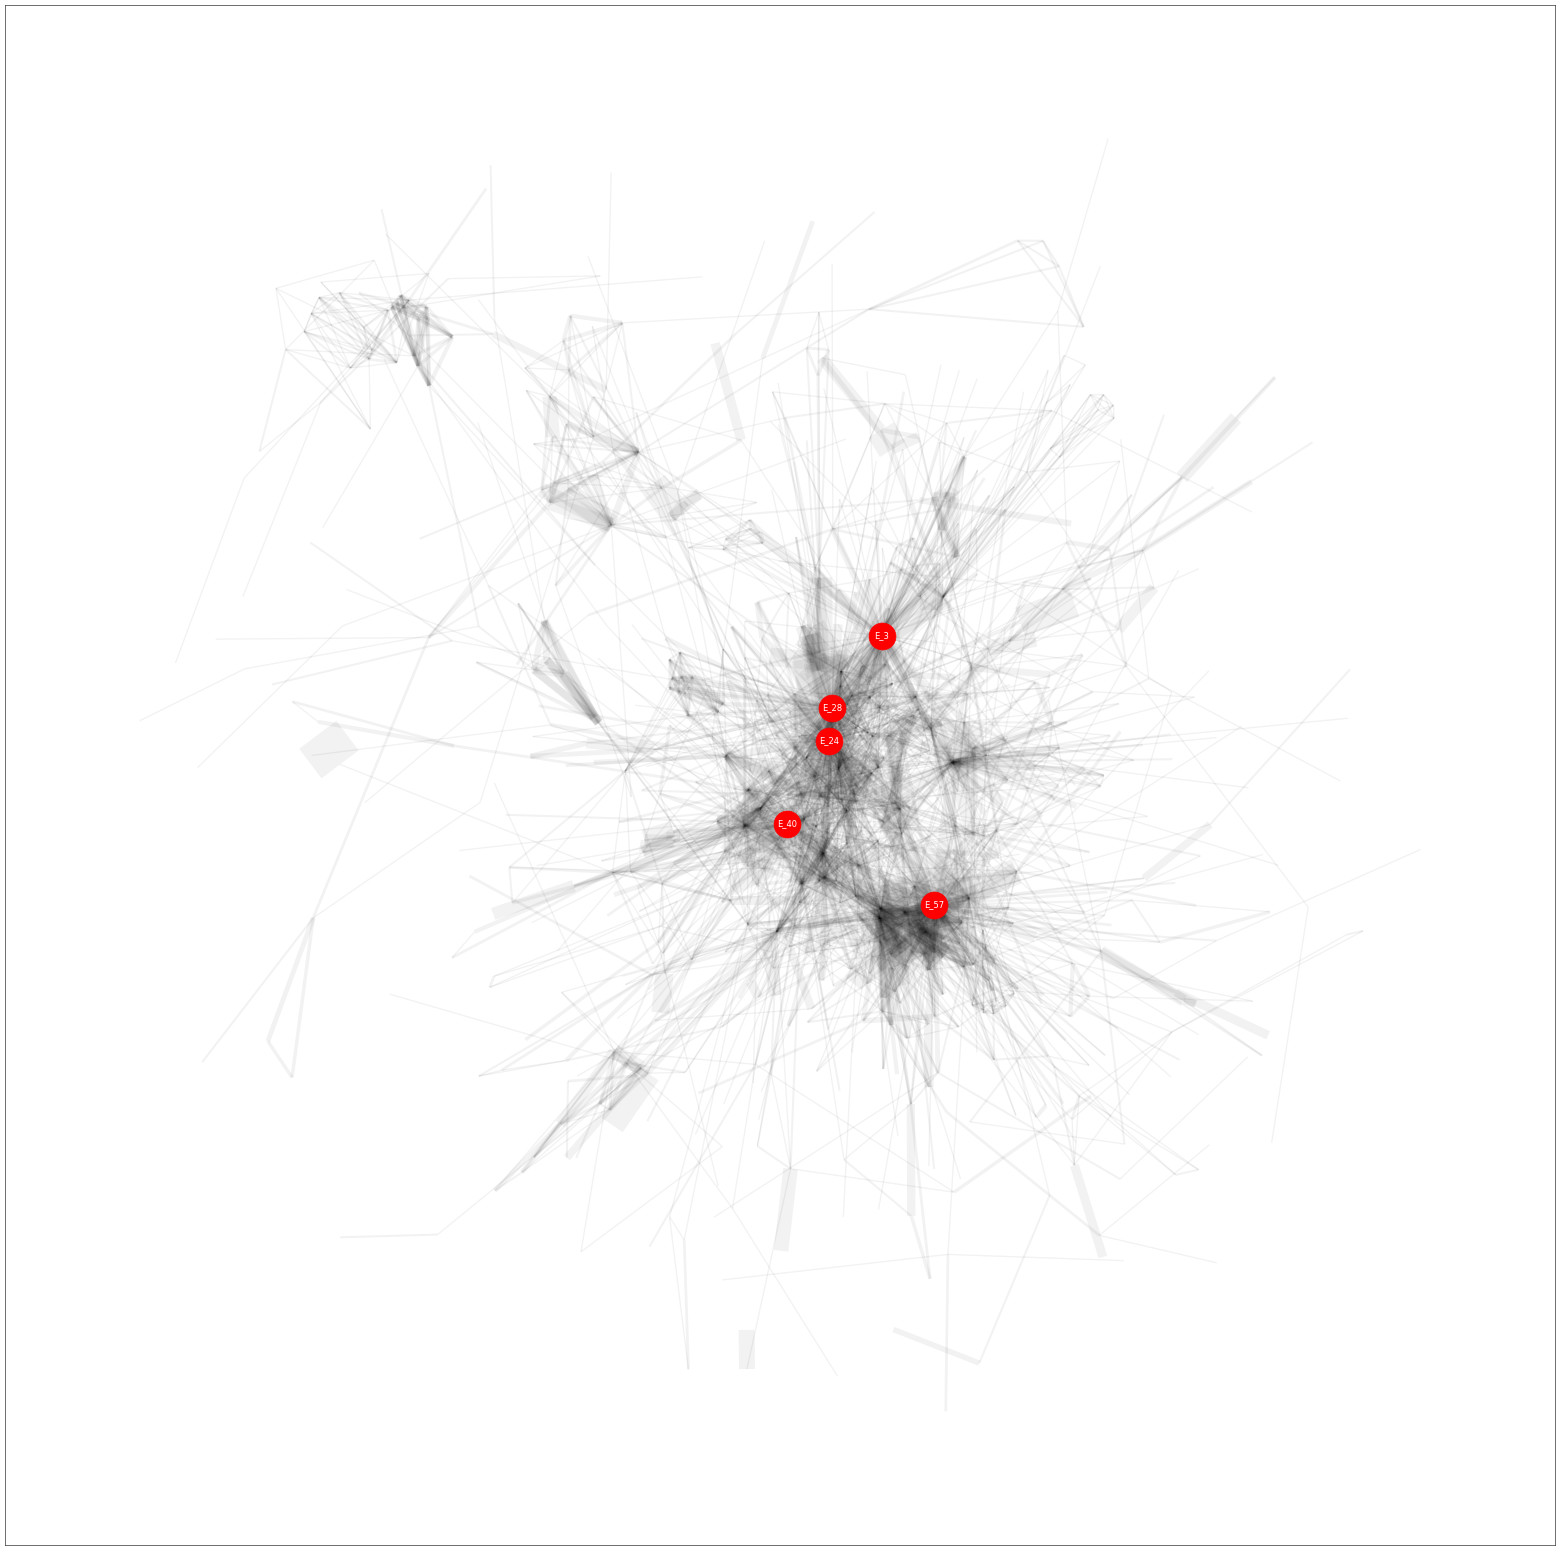

In [22]:
plot_hubs(sub_S,"degree",80.0,"data_network_high_degree_hubs")

Plot high betweenness centrality hubs only

Top betweenness datasets: ['E_24', 'E_57', 'E_3', 'E_180', 'E_28']


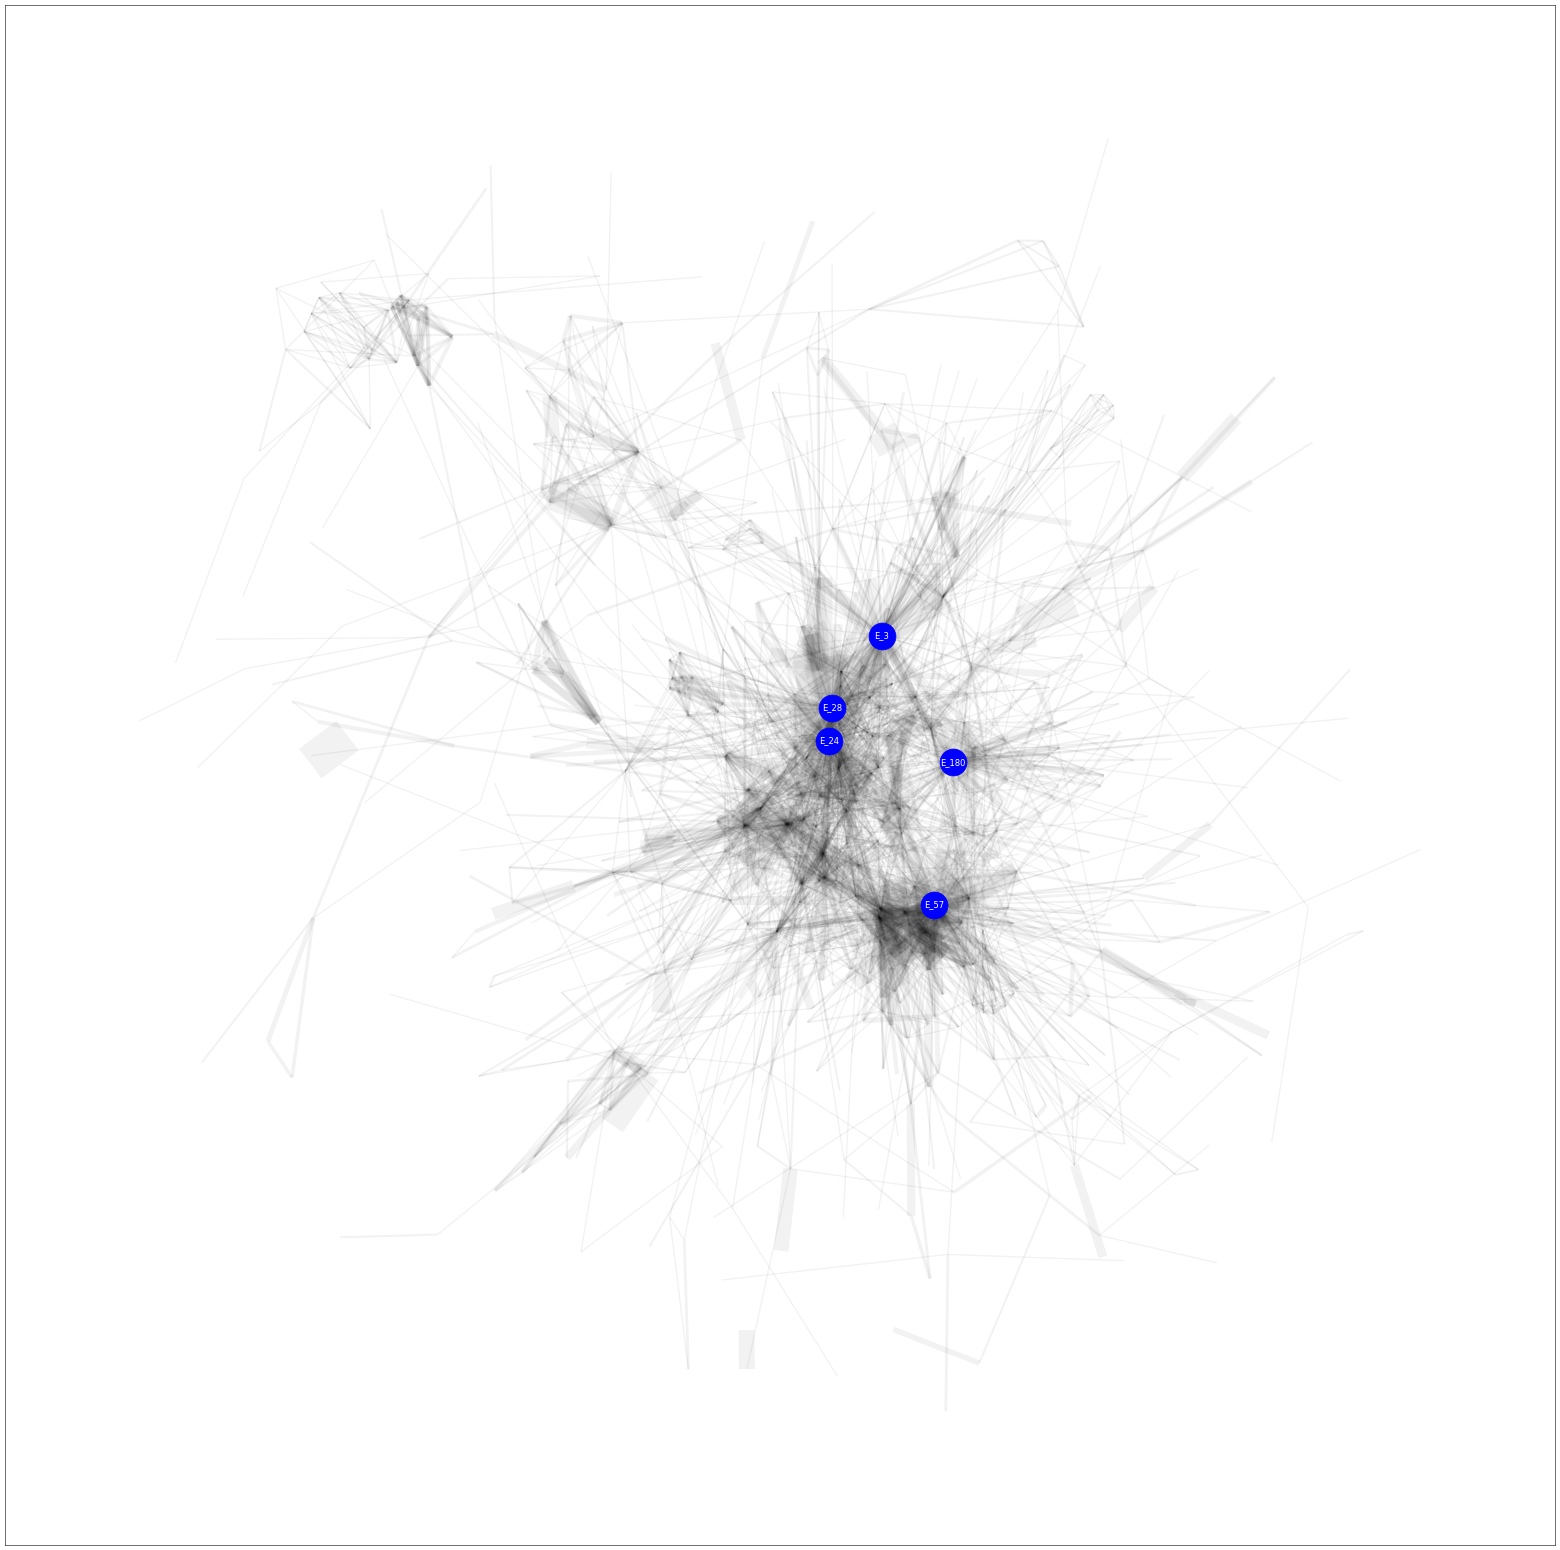

In [23]:
plot_hubs(sub_S,"between",0.09,"data_network_most_between_hubs")

Make a plot for the paper that shows both types of hubs (high degree centrality, betweenness centrality) combined

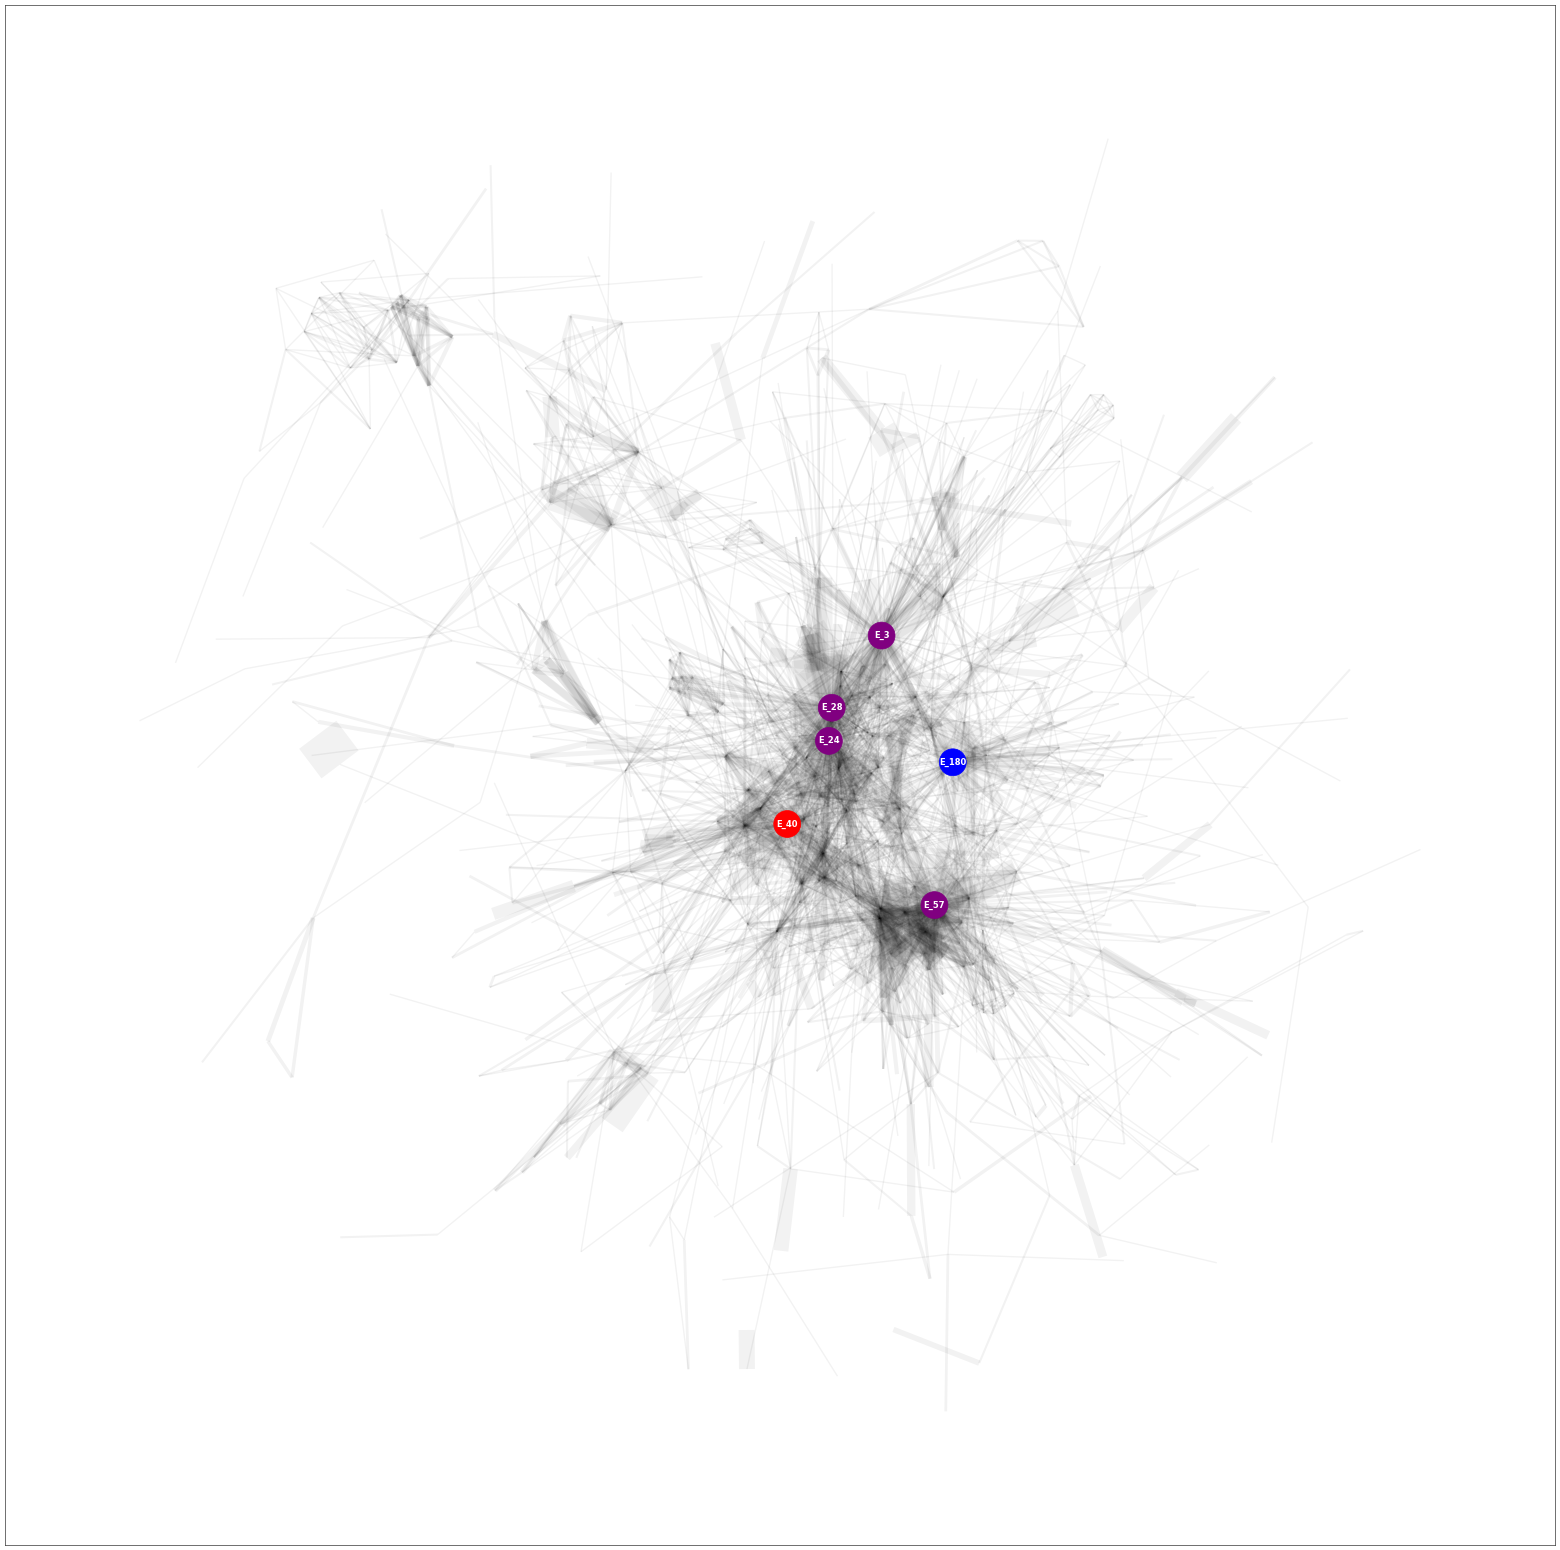

In [24]:
top_degree = [x for x,y in S.nodes(data=True) if y['degree']>=80.0]
top_between = [x for x,y in S.nodes(data=True) if y['between']>=0.09]
deg_bet = list(set(top_between).intersection(set(top_degree)))

only_degree = list(set(top_degree) - set(deg_bet))
only_between = list(set(top_between) - set(deg_bet))
all_nodes = list(set.union(set(only_degree), set(only_between), set(deg_bet)))
subgraph = S.subgraph(all_nodes)

color_map = []
for n in subgraph.nodes():
    if n in only_degree:
        color_map.append('red')
    elif n in only_between:
        color_map.append('blue')
    else:
        color_map.append('purple')

fig = plt.figure(1, figsize=(40, 40), dpi=50)
pos = nx.spring_layout(sub_S, k=0.2, seed=42)

all_edges = sub_S.edges()
weight = [all_edges[(u, v)]['weight'] for u,v in all_edges] 

nx.draw_networkx_edges(sub_S,
                       pos=pos,
                       width=weight,
                       edge_color="black",
                       alpha=0.05);

nx.draw_networkx(subgraph, 
                 pos=pos,
                 width=0,
                 node_size=1500,
                 node_color=color_map, 
                 with_labels=True, 
                 font_color="white", 
                 font_weight="bold")

# plt.savefig('../figures/data_network_hubs.png', 
#             transparent=True, 
#             bbox_inches='tight', 
#             pad_inches=0, 
#             dpi=500)    

plt.show()

`STUDY` shortest path 
- Steps between data from any two studies

In [25]:
sample_node_1 = data_nodes.REF_DATA.iloc[0]
sample_node_2 = data_nodes.REF_DATA.iloc[20]

shortest_path(S, sample_node_1, sample_node_2)

SOURCE found: National Crime Surveys: National Sample, 1973-1983 

TARGET found: Violence Against Women: Developmental Antecedents Among Black, Caucasian, and Hispanic Women in the United States, 1987-1988 and 1992-1994 

Shortest SOURCE to TARGET path: 4 

	 Path link: National Crime Surveys: National Sample, 1973-1983 | Path link: National Crime Surveys: National Sample, 1973-1983 

	 Path link: National Incident-Based Reporting System, 2002 | Path link: National Incident-Based Reporting System, 2002 

	 Path link: National Household Survey on Drug Abuse, 1992 | Path link: National Household Survey on Drug Abuse, 1992 

	 Path link: National Survey of Families and Households, Wave 1: 1987-1988, [United States] | Path link: National Survey of Families and Households, Wave 1: 1987-1988, [United States] 

	 Path link: Violence Against Women: Developmental Antecedents Among Black, Caucasian, and Hispanic Women in the United States, 1987-1988 and 1992-1994 | Path link: Violence Against Wo

## Detect data communities
Cliques of `DATA` used in same `PAPER`

Prediction: find clusters of analytical utility, meaning the data have similar variables, coverage, scope

Algorithm: k-clique percolation (k-cliques work better with dense networks; we compare to spectral approaches, which use the underlying structures of the subgraphs - if we find similar community composition, this is confirmatory)

Communities detected at k of 3:  41
Communities detected at k of 4:  36
Communities detected at k of 5:  32
Communities detected at k of 6:  27


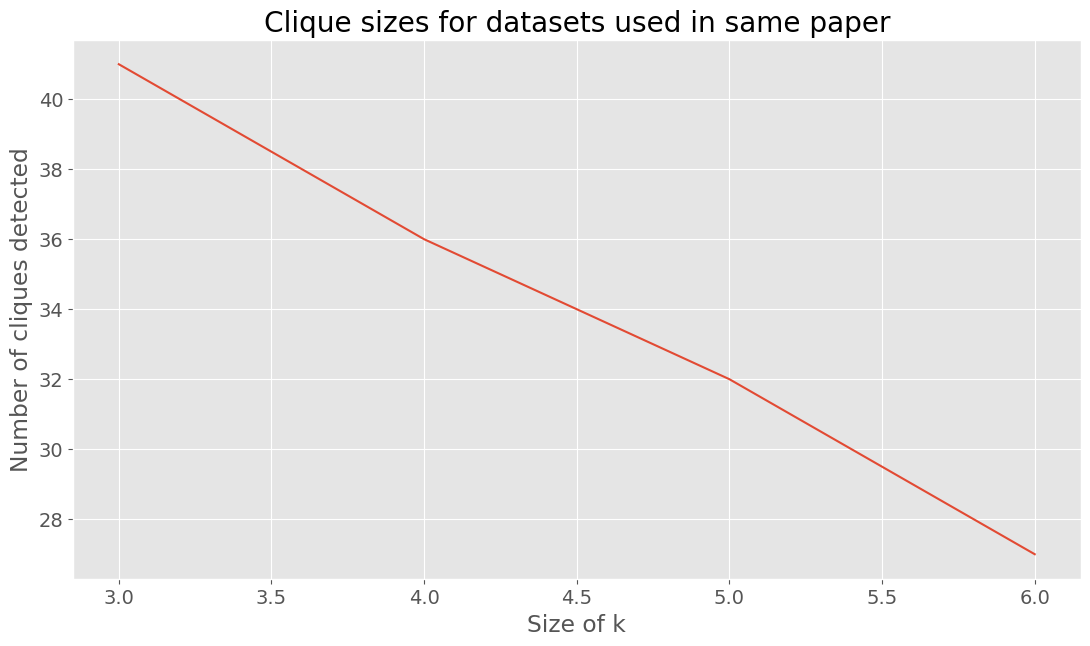

In [26]:
nx.info(S)

kmin, kmax = 3, 6

k_values = []
clique_lens = []

for k in range(kmin, kmax+1):
    clique_result = detect_cliques(S, k)
    clique_lens.append(len(clique_result))
    k_values.append(k)
    
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14})
fig = plt.figure(figsize=(13,7))
plt.plot(k_values, clique_lens)
plt.title("Clique sizes for datasets used in same paper")
plt.xlabel("Size of k")
plt.ylabel("Number of cliques detected")
plt.show()

In [27]:
data_cliques = detect_cliques(S, 3)

Communities detected at k of 3:  41


In [28]:
data_cliques_results = make_cliques_df(data_cliques, "data", data_nodes, "data_cliques_labels")
data_cliques_results

,community,degree,REF_DATA,STUDY,NAME,SERIES,SERIES_TITLE,OWNER,FUNDINGAGENCY,GEO,TERMS,ORIGRELDATE,label_terms,multi,color
0,0,203,S_4297,4297,"Survey of Texas Adults, 2004",None,None,NACDA,RGK Center for Philanthropy and Community Service,Texas; United States,charitable donations; demographic characterist...,2005-09-22 00:00:00,"demographic characteristics, employment, income",False,0
1,0,27,E_12,9388,"Census of Governments, 1987: Government Organi...",12.0,Census of Governments Series,ICPSR,None,United States,census data; counties; government personnel; g...,1990-10-16 00:00:00,"demographic characteristics, employment, income",False,0
2,0,15,E_386,26681,CRELES: Costa Rican Longevity and Healthy Agin...,386.0,CRELES: Costa Rican Longevity and Healthy Agin...,NACDA,Wellcome Trust (United Kingdom),Central America; Costa Rica; Global,aging; health behavior; health services utiliz...,2010-07-21 14:39:50,"demographic characteristics, employment, income",False,0
3,0,12,S_34647,34647,Japan 2009 National Survey on Family and Econo...,None,None,ICPSR,United States Department of Health and Human S...,Asia; Global; Japan,attitudes; child care; child rearing; children...,2013-06-06 10:22:54,"demographic characteristics, employment, income",False,0
4,0,45,E_886,34540,"National Prisoner Statistics, 1978-2011",886.0,National Prisoner Statistics (NPS) Series,NACJD,United States Department of Justice. Office of...,United States,correctional system; demographic characteristi...,2013-06-25 10:59:58,"demographic characteristics, employment, income",False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,39,5,S_8612,8612,Violence and Crime in Cross-National Perspecti...,None,None,NACJD,United States Department of Health and Human S...,Africa; Asia; Central America; Europe; Global;...,assault; crime; international crime statistics...,1987-02-26 00:00:00,"courts, crime, international crime statistics",False,39
651,39,4,S_9258,9258,"Correlates of Crime: A Study of 52 Nations, 19...",None,None,NACJD,None,Global,crime; economic conditions; national economy; ...,1990-03-02 00:00:00,"courts, crime, international crime statistics",False,39
652,40,2,S_30022,30022,NCAA Division I and II Graduation Success Rate...,None,None,ICPSR,None,United States,colleges; eligibility; graduates; graduation; ...,2011-01-07 12:55:40,"student athletes, eligibility, scholarships",False,40
653,40,2,S_26801,26801,"NCAA Division I Academic Progress Rate, 2003-2014",None,None,ICPSR,None,United States,Academic Progress Rate; educational assessment...,2010-01-05 15:51:44,"student athletes, eligibility, scholarships",False,40


In [29]:
pd.set_option('display.max_colwidth', None, 'display.max_colwidth', None)

multi_comm = data_cliques_results[data_cliques_results.multi==True]
print("Nodes in more than one clique:",len(multi_comm))

membership_num = multi_comm.groupby('REF_DATA')['community'].count().sort_values(ascending=False)
print("Node with largest membership number:",membership_num.max())
membership_num.value_counts()

data_cliques_groups = group_cliques(data_cliques_results, "data", "data_cliques_groups")
data_cliques_groups

Nodes in more than one clique: 43
Node with largest membership number: 3


,community,members,label_terms
0,0,461,"demographic characteristics, employment, income"
461,1,28,"international conflict, war, nations"
489,2,14,"substance abuse treatment, treatment programs, residential programs"
503,3,11,"offenders, domestic violence, victimization"
514,4,8,"public opinion,political attitudes, political behavior"
522,5,7,"behavior problems, human behavior, parental attitudes"
529,6,6,"census data, historical data, nineteenth century"
535,7,5,"violence, internal political conflict, political opposition"
540,8,5,"arts participation, dance, entertainment"
545,9,5,"crime statistics, homicide,arrests"


Graph named 'S' with 632 nodes and 2892 edges


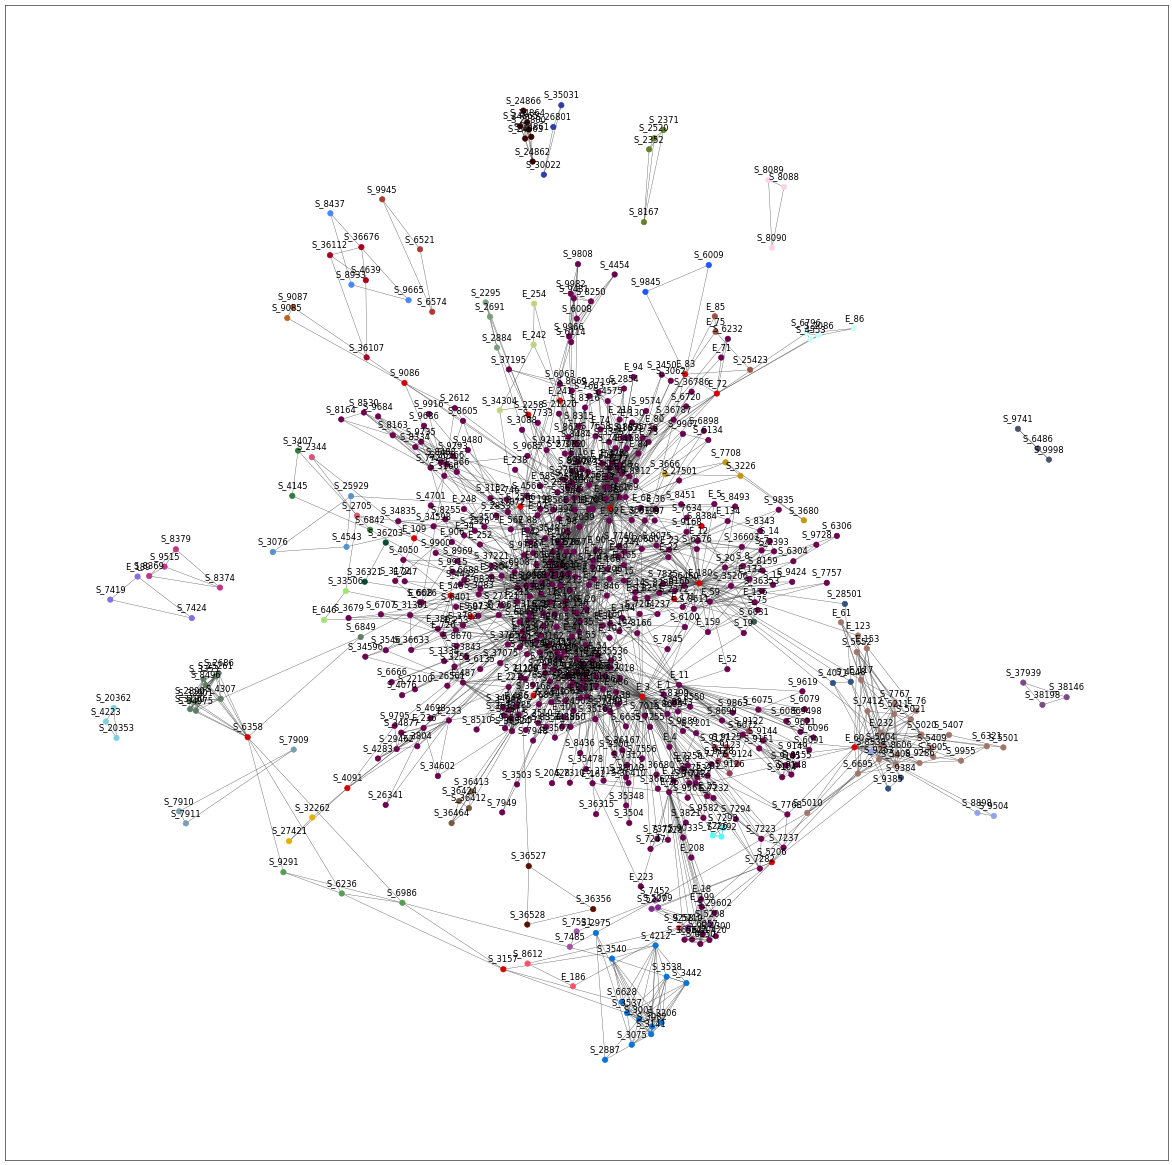

In [30]:
data_cliques  = plot_cliques(S, "data", data_cliques_results, "data_communities_plot")

In [31]:
# save_gexf(data_cliques, "data_cliques")

Make files for Tableau visualization (Nodes, Edges, Edges_info)

In [32]:
sub_nodes = data_cliques_results['REF_DATA']
subgraph = S.subgraph(sub_nodes)
print(nx.info(subgraph))

comm_dict = dict(zip(data_cliques_results.REF_DATA, data_cliques_results.community))
labels_dict = dict(zip(data_cliques_results.REF_DATA, data_cliques_results.label_terms))
colors_dict = dict(zip(data_cliques_results.REF_DATA, data_cliques_results.color))
    
nx.set_node_attributes(subgraph, comm_dict, 'community')
nx.set_node_attributes(subgraph, labels_dict, 'label')
nx.set_node_attributes(subgraph, colors_dict, 'color')
    
def nodes2df(pos_dict):
    df = pd.DataFrame()
    df["NodeName"] = pos_dict.keys()
    df["X"] = [value[0] for value in pos_dict.values()]
    df["Y"] = [value[1] for value in pos_dict.values()]
    return df

def edges2dfs(weight_dict):
    the_keys = list(weight_dict.keys())
    the_values = list(weight_dict.values())
    
    node_Index = []
    NodeName = []
    edge_Index = []
    EdgeSize = []
    
    for i in range(len(weight_dict)):
        this_study1 = the_keys[i][0]
        this_study2 = the_keys[i][1]
        
        node_Index.append(i)
        node_Index.append(i)       
        NodeName.append(this_study1)
        NodeName.append(this_study2)
        
        edge_Index.append(i)
        EdgeSize.append(int(float(the_values[i])))
    edge_df = pd.DataFrame({"NodeName":NodeName,"c_Index":node_Index})
    edge_info_df = pd.DataFrame({"EdgeSize":EdgeSize,"c_Index":edge_Index})
    
    return edge_df,edge_info_df

weights = nx.get_edge_attributes(subgraph, 'weight')
pos = nx.spring_layout(subgraph, k=3, iterations=1000, seed=42)

study_nodes_df = nodes2df(pos)
study_edges_df, study_edges_info_df = edges2dfs(weights)

# study_nodes_df.to_csv("../outputs/data_nodes_df.csv",index=False)
# study_edges_df.to_csv("../outputs/data_edges_df.csv",index=False)
# study_edges_info_df.to_csv("../outputs/data_edges_info_df.csv",index=False)

Graph named 'S' with 632 nodes and 2892 edges
